# Saliency maps examples with VGG16

## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import keras
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.applications import VGG16
from keras import activations
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
print(f'sys.version: {sys.version}')
print(f'tf.version: {tf.__version__}')
print(f'keras.version: {keras.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
tf.version: 1.11.0
keras.version: 2.2.4


In [4]:
DATASET_PATH = '../datasets/playground/'

## 2. Load VGG16 model

In [5]:
# pretrained VGG16 on ImageNet
model = VGG16(weights='imagenet', include_top=True)
layer_idx = utils.find_layer_idx(model, 'predictions')

# swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 3. Load some images

In [6]:
img_names = [DATASET_PATH + img_name for img_name in os.listdir(DATASET_PATH)]
print(img_names)

['../datasets/playground/19_Rainy.jpg', '../datasets/playground/20160524_GF1_00051.png', '../datasets/playground/20160524_GF2_00047.png', '../datasets/playground/2664313169_e245dd4081.jpg', '../datasets/playground/2806751936_fcd5ae416e.jpg', '../datasets/playground/583859889_e0a9bed109.jpg']


In [7]:
images = []
for img_name in img_names:
    images.append(utils.load_img(img_name, target_size=(224, 224)))

/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tudor/anaconda2/envs/py36_tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## 4. Play with vgg16 model (predict, decode_predictions)

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

In [8]:
img = images[0]
scores = model.predict(img[np.newaxis])
class_tuples = keras.applications.vgg16.decode_predictions(scores)
print(f'{scores.shape}, {scores[0, :7]} ...')
print(f'{class_tuples[:10]}')

(1, 1000), [-4.6021256  -0.59493935 -3.0310376  -6.2020736  -2.8752234  -1.7880607
 -1.5831051 ] ...
[[('n02892201', 'brass', 15.916089), ('n04149813', 'scoreboard', 15.529552), ('n07565083', 'menu', 13.239639), ('n03598930', 'jigsaw_puzzle', 12.036728), ('n03777754', 'modem', 11.47676)]]


In [9]:
scores = scores.squeeze()
print(scores.shape)

(1000,)


## 5. Save imagenet class names

In [10]:
class_tuples = keras.applications.vgg16.decode_predictions(np.arange(1000)[np.newaxis], top=1000)[0][::-1]
class_names = [t[1] for t in class_tuples]
print(class_names[:7])
print(class_names[-7:])

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray']
['gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet_tissue']


## 6. Look at some saliency maps

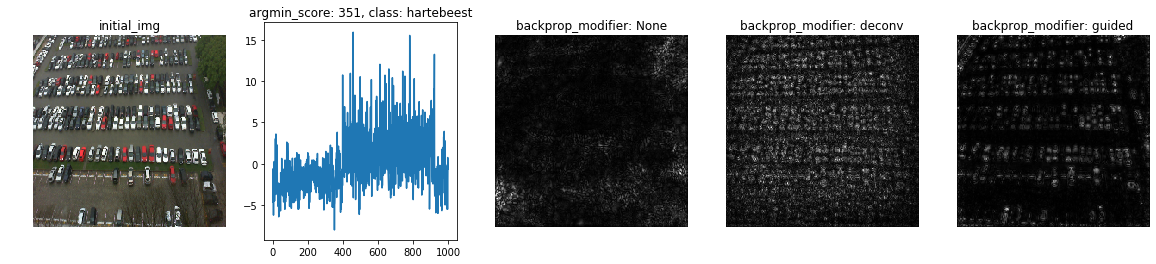

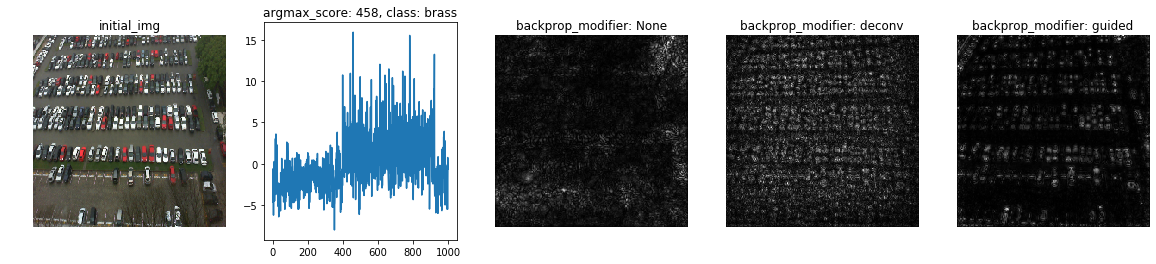

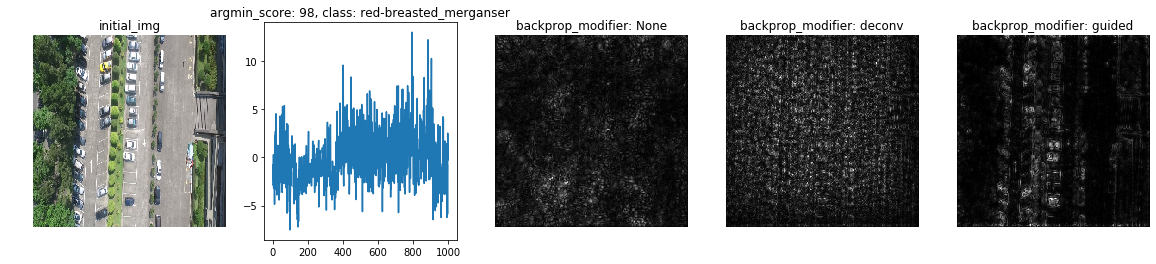

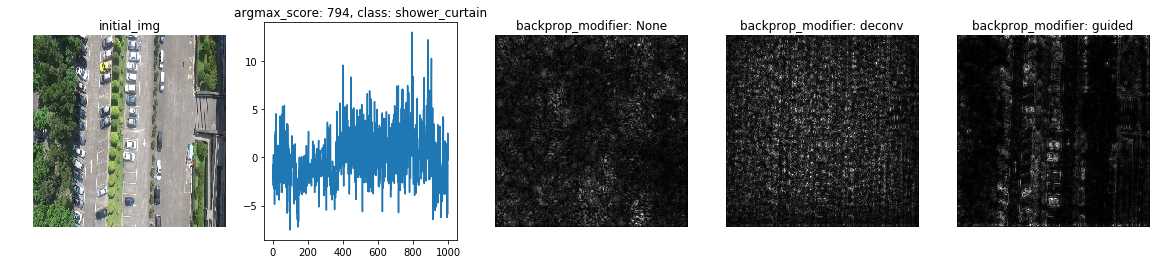

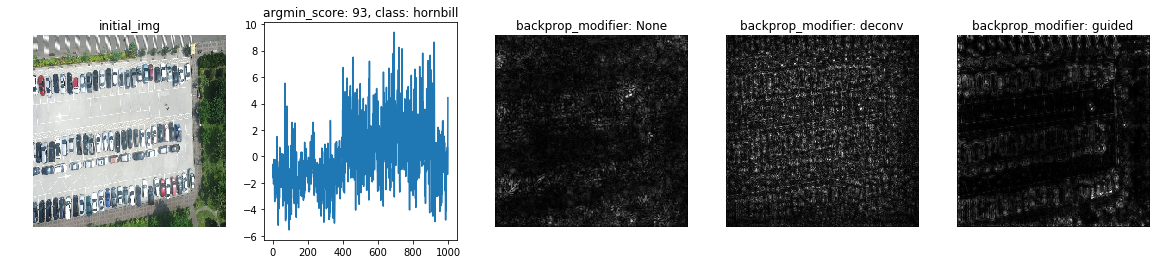

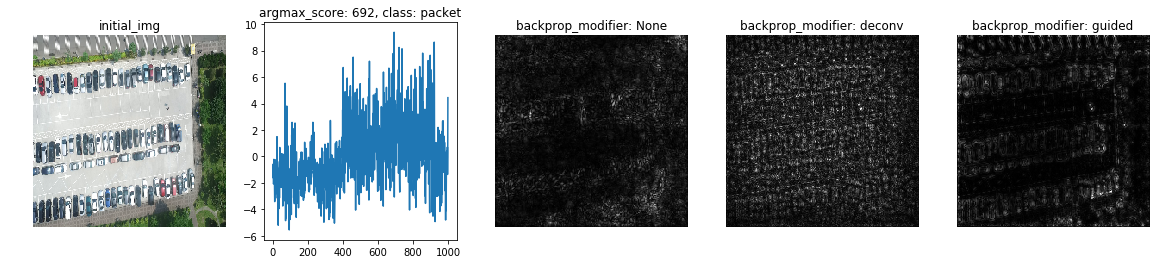

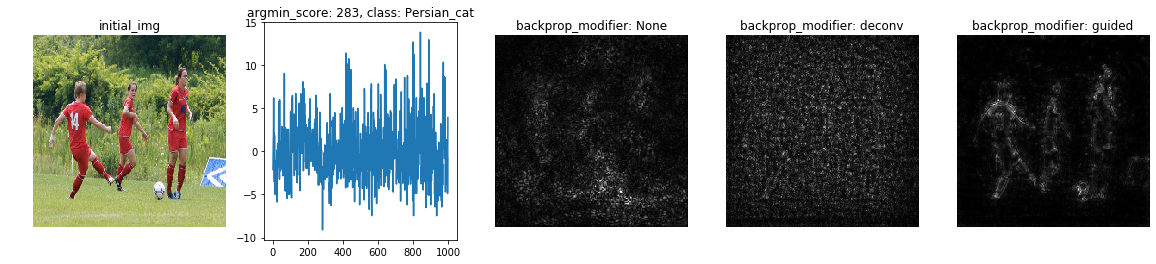

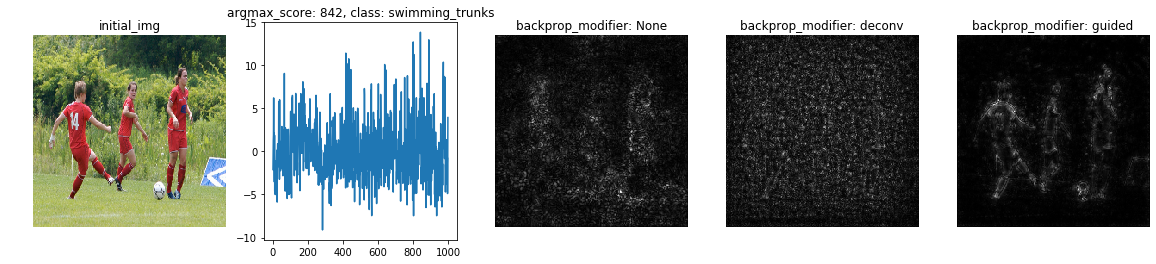

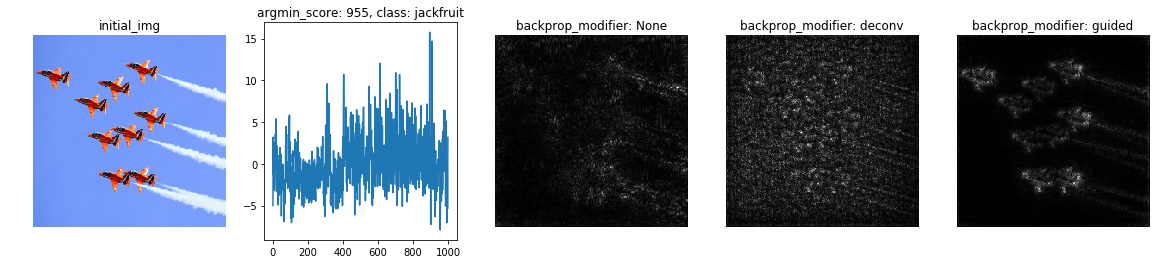

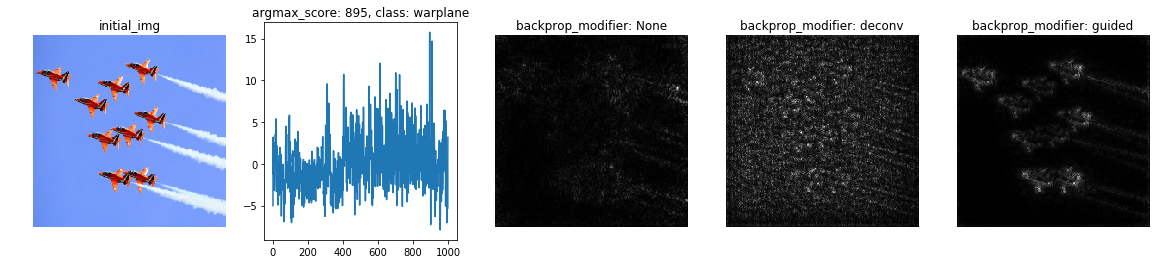

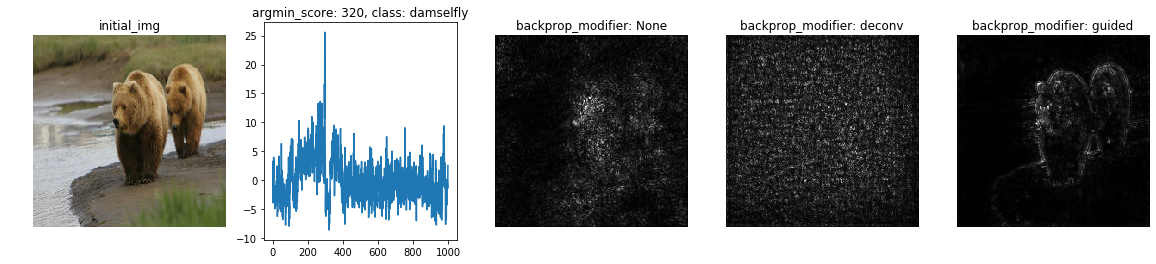

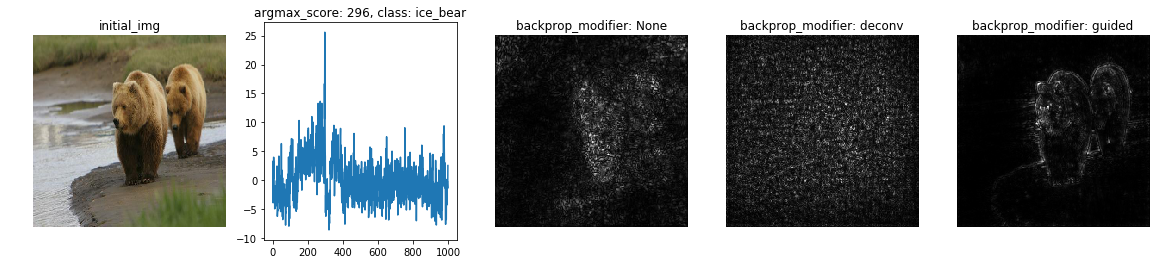

In [11]:
for img in images:
    scores = model.predict(img[np.newaxis]).squeeze()
    max_score = np.max(scores)
    min_score = np.min(scores)
    argmax_score = np.argmax(scores)
    argmin_score = np.argmin(scores)
    
    for mode in ['min', 'max']:
        plt_title = None
        if mode == 'min':
            class_id = argmin_score
            class_name = class_names[argmin_score]
            plt_title = f'argmin_score: {argmin_score}, class: {class_name}'
        else:
            class_id = argmax_score
            class_name = class_names[argmax_score]
            plt_title = f'argmax_score: {argmax_score}, class: {class_name}'
        
        plt.figure(figsize=(20, 4))
        plt.subplot(1, 5, 1)
        plt.title('initial_img')
        plt.axis('off')
        plt.imshow(img)

        plt.subplot(1, 5, 2)
        plt.title(plt_title)
        plt.plot(scores)

        for idx, modifier in enumerate([None, 'deconv', 'guided']):
            plt.subplot(1, 5, 3 + idx)
            plt.title(f'backprop_modifier: {modifier}')
            plt.axis('off')
            grads = visualize_saliency(model, layer_idx,
                                       filter_indices=class_id,
                                       seed_input=img,
                                       backprop_modifier=modifier)
            plt.imshow(grads, cmap='gray')